# Этап 1: Анализ весов и потенциала сжатия

Прежде чем сжимать модель, нам нужно понять:
1. Сколько она занимает сейчас?
2. Как распределены её веса?
3. Есть ли аномалии (outliers), которые помешают квантованию?

In [6]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from src.model import GPTLanguageModel, device

# Инициализируем модель
model = GPTLanguageModel().to(device)
try:
    model.load_state_dict(torch.load('model_ckpt.pt', map_location=device))
    print("✅ Загружены обученные веса из model_ckpt.pt")
except:
    print("⚠️ Чекпоинт не найден, используем случайные веса")

print(f"Используемое устройство: {device}")
print(f"Количество параметров: {sum(p.numel() for p in model.parameters())/1e6:.2f}M")

✅ Загружены обученные веса из model_ckpt.pt
Используемое устройство: mps
Количество параметров: 10.79M


### 1. Анализ занимаемой памяти
Посчитаем реальный объем памяти в мегабайтах для FP32 (стандарт) и FP16 (половинная точность).

In [7]:
def get_model_size_mb(mdl):
    # Считаем сумму байт для всех параметров
    param_size = sum(p.nelement() * p.element_size() for p in mdl.parameters())
    buffer_size = sum(b.nelement() * b.element_size() for b in mdl.buffers())
    return (param_size + buffer_size) / 1024**2

size_fp32 = get_model_size_mb(model)
print(f"Размер модели (FP32): {size_fp32:.2f} MB")
print(f"Размер модели (FP16): {size_fp32/2:.2f} MB (теоретически)")

Размер модели (FP32): 50.16 MB
Размер модели (FP16): 25.08 MB (теоретически)


### 2. Визуализация распределения весов
Посмотрим на гистограмму весов одного из слоев. Это ключевой момент для понимания квантования.

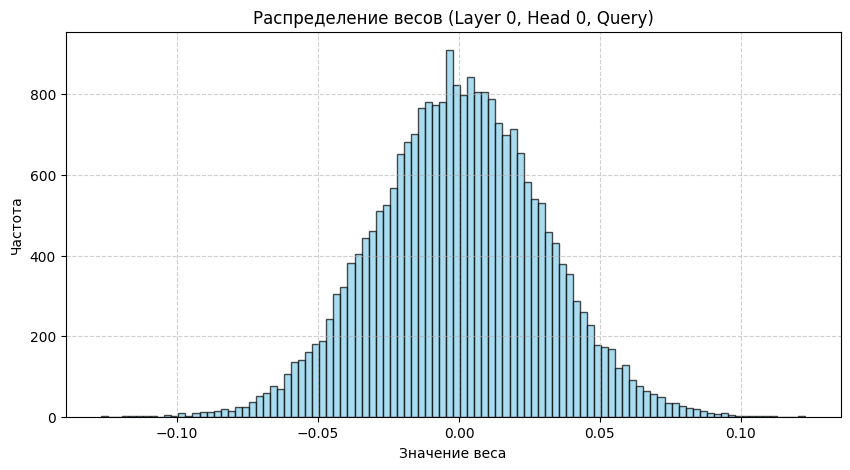

Максимальное значение: 0.1229
Минимальное значение: -0.1271
Среднее (mean): 0.0001
Отклонение (std): 0.0297


In [8]:
# Возьмем веса матрицы Query в первом блоке внимания
weights = model.blocks[0].sa.heads[0].query.weight.data.cpu().flatten().numpy()

plt.figure(figsize=(10, 5))
plt.hist(weights, bins=100, color='skyblue', edgecolor='black', alpha=0.7)
plt.title("Распределение весов (Layer 0, Head 0, Query)")
plt.xlabel("Значение веса")
plt.ylabel("Частота")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

print(f"Максимальное значение: {weights.max():.4f}")
print(f"Минимальное значение: {weights.min():.4f}")
print(f"Среднее (mean): {weights.mean():.4f}")
print(f"Отклонение (std): {weights.std():.4f}")